In [15]:
import pickle, copy, json,  h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps
from random import shuffle
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import la_forge.utils as lf_utils
lf_utils.set_publication_params({'text.usetex':False})
fig_dir = '/home/baierj/projects/hasasia2/hasasia2_paper/figures'

In [16]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [17]:
import seaborn as sns
#sns.light_palette("seagreen", as_cmap=False, n_color = )
cbind = sns.color_palette("colorblind")
cbind_map1 = sns.color_palette(cbind, as_cmap=False, n_colors=15,)

In [19]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as hutils
import hasasia.skymap as hsky
#from hasasia.utils import detection_prob as has_dp
#from hasasia.utils import false_dismissal_prob as has_fdp
# these moved to attributes of skymap
from hasasia.sensitivity import psd_from_background_realization as psd
#import holodeck as holo

In [5]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

# Setting various healpy quantities and GW source sky positions.
# NSIDE = 16
# NPIX = hp.nside2npix(NSIDE)
# IPIX = np.arange(NPIX)
# theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [20]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]
def start_filter(psrs, start_year=10):
    return [p for p in psrs if min(p.toas) < start_year*365.25*24*3600 ]
fyr = 1/(365.25*24*3600)
days = 24*3600
yr_sec = 365.25*24*3600
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)

In [21]:
def get_sliced_spectra(psrs, 
                       start_mjd=1,
                       end_mjd = None,
                       ):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
    
    sigma_correction : ?
        ???
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    for idx, psr in enumerate(psrs_copy):
        # filter the data around to the appropriate slice
        #print("N_toa = ", len(psr.toas))
        psr.filter_data(start_time=start_mjd, end_time=end_mjd)
        #print("after filter = ", len(psr.toas)) 
        # If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size == 0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)
    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for idx, p in enumerate(psrs_cut):
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        #print(f"psr spectra {idx} is done")
        spectra.append(sp)
    print(f"PTA spectrum with {len(spectra)} psrs created.")
    return spectra

In [22]:
def strain_and_chirp_mass_to_luminosity_distance(h, M_c, f0):
    return (4*hsky.c.c / (h * hsky.u.m/hsky.u.m)
            * np.power(hsky.c.G * M_c * hsky.u.Msun/hsky.c.c**3, 5/3)
            * np.power(np.pi * f0 * hsky.u.Hz, 2/3)).to('Mpc')

def calculate_detection_volume(skymap, SNR, frequency, M_c, NSIDE=8):
    """
    Calculates the detection volume of your PTA at a given frequency.

    Parameters
    ==========
    skymap - hasasia.skymap
        the hasasia.skymap to use
    SNR - float
        the signal to noise to referene detection volume to
    frequency - float
        the frequency at which to calculate detection volume
    M_c - float
        the chirp mass at which to reference detection volume
    NSIDE - int
        the NSIDE used to create the heaply skymap
    Returns
    =======
    volume - float
        the detection volume in Mpc^3
    """
    dA = hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)
    f_idx = np.argmin(abs(skymap.freqs - frequency))
    h0 = skymap.h_thresh(SNR=SNR)[f_idx]
    return dA*np.sum(
        strain_and_chirp_mass_to_luminosity_distance(h0, M_c, skymap.freqs[f_idx])**3
        ).value

In [86]:
snr_3sig = 3.7145
# from scipy import integrate
# fap3sigma = integrate.quad(lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2*x**2), 3, np.inf)[0]
F0_3sig = 8.898 # hutils._solve_F0_given_SNR(snr_3sig)
#print("false alarm rate for 3sigma: ", hutils.fap(F0_3sig))
print("F0 for 3sigma: ", F0_3sig)
print("S/N for 3sigma: ", snr_3sig)
# a fap of 0.0013 corresponds to a 3-sigma detection under a gaussian null distribution
# but here it corresponds to a S/N of 3.7145
# and a F0 of 8.898 for the hasasia detection statistic

F0 for 3sigma:  8.898
S/N for 3sigma:  3.7145


In [24]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]
def sky_ave_detect(sm,snr=snr_3sig):
    snr /= 2
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/sm.Tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work
def sky_detect(sm,snr=snr_3sig):
    snr /= 2
    return snr*np.sqrt(sm.S_eff/sm.tspan)
def most_likely_freq(fbins, DPs):
    return (np.sum(DPs*fbins)/np.sum(DPs))
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work
fyr = 1/(365.25*24*3600)
days = 24*3600
yr_sec = 365.25*24*3600
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)
inj_gwb_hc = np.sqrt(hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)*freqs)

# 1) Load `hsen.Pulsars` created in `creating_pta.ipynb`

In [25]:
proj_dir = '/home/baierj/projects/hasasia2/pta_sensitivity_tuning'
#proj_dir = '.'
def reset_psrs():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2/gpta_psr_{i}_v2.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` in from `creating_pta.ipynb`.")
    return gpta_psrs_40yrs
def reset_psrs_half_amp():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2_halfAmp/gpta_psr_{i}_v2_halfAmp.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` with half the GWB injected")
    return gpta_psrs_40yrs
gpta_psrs_40yrs = reset_psrs()
gpta_psrs_40yrs_halfAmp = reset_psrs_half_amp()

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
Loaded  157  `hsen.Pulsars` with half the GWB injected


### Confirm that the spectrum looks good.

In [14]:
full_specs_gpta = []
for p in tspan_filter(gpta_psrs_40yrs):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    full_specs_gpta.append(sp)
full_GWBSC = hsen.GWBSensitivityCurve(spectra=full_specs_gpta, orf='hd', autocorr=False)
full_GPTA_GWB_SNR = full_GWBSC.SNR(S_h)
gwb_label = f"injected GWB has SNR={full_GPTA_GWB_SNR:.3f}"
print(f"GPTA GWB SNR {full_GPTA_GWB_SNR:.2f}")

2024-12-14 11:25:13.979553: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


GPTA GWB SNR 32.04


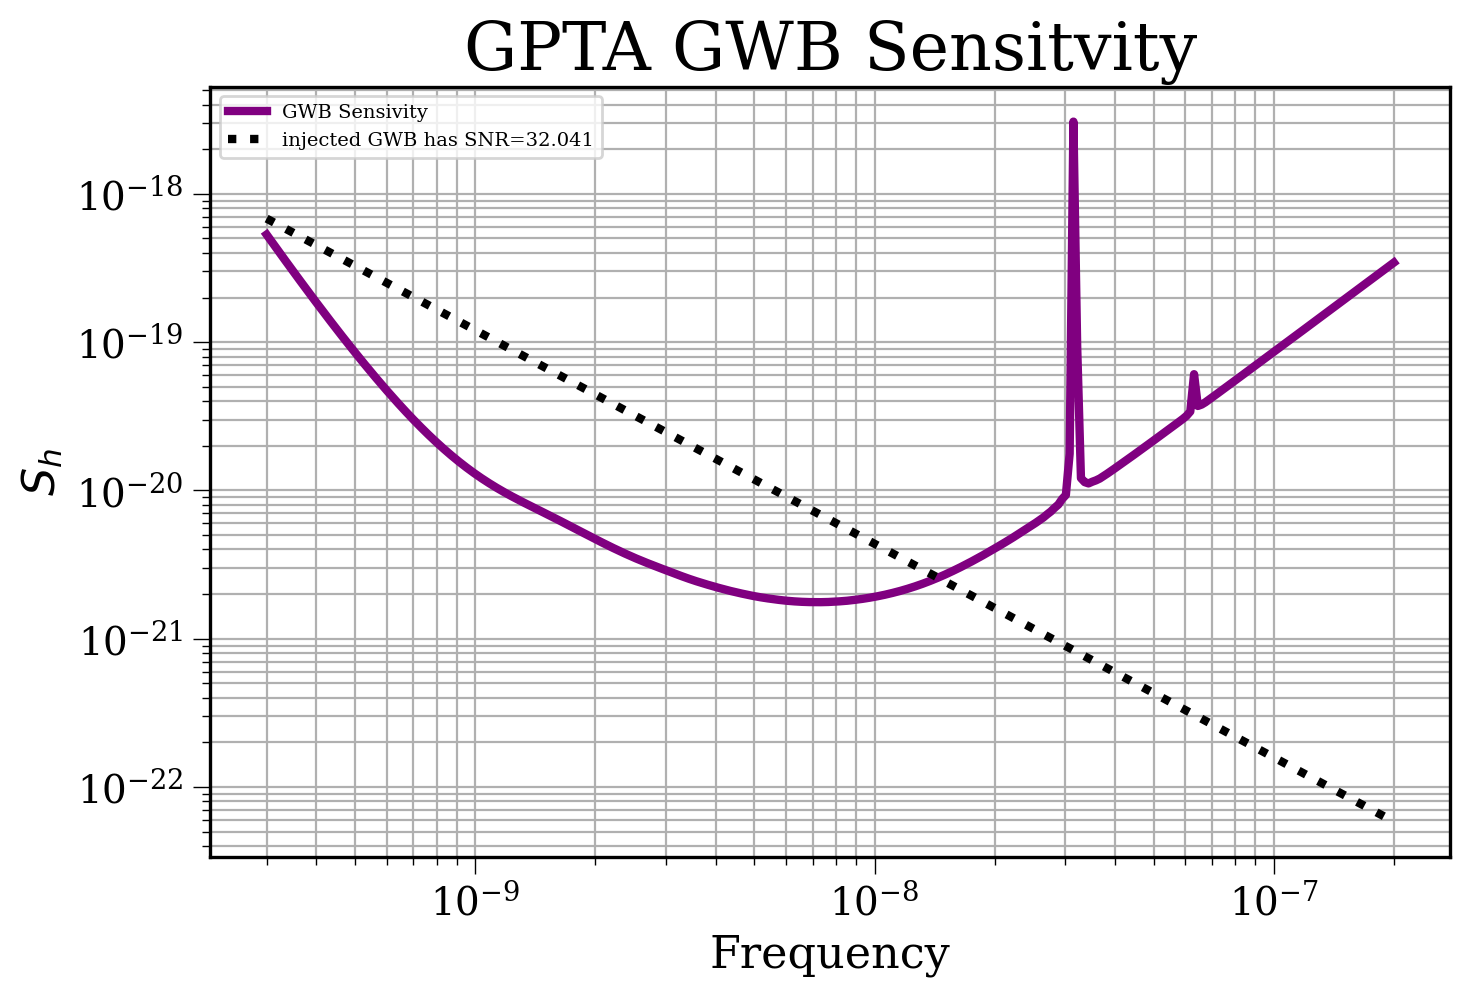

In [48]:
# Plot GWB SC
plt.figure(figsize=[8,5])
plt.loglog(full_GWBSC.freqs, full_GWBSC.S_eff,label="GWB Sensivity", color = "Purple", linewidth= 3)
plt.loglog(full_GWBSC.freqs, S_h, color = 'k', linewidth=3, linestyle = ":", label = gwb_label)
plt.legend(loc='upper left')
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('$S_h$', fontsize=16)
plt.title('GPTA GWB Sensitvity', fontsize = 24)
plt.grid(which='both')
plt.show()

In [26]:
## Sam lib data
### used with permission from Emiko Gardiner
#Description: 500 samples (drawn from a uniform param space similar to the one in the awg paper), each of which have 100 realizations. sorted them by how well they match the 1/10yr 15yr GWB characteristic strain detection, cuz at that frequency the strain amplitude and spectral index are pretty covariant. Ranking from best to worst sample is in the npz array, but the 10 best are, in order
#202 103 452 111 117  79 180 276 245 479

#the hc_bg and hc_ss in the hdf file are shaped (nsamples, nfreqs, nreals) and (nsamples, nfreqs, nreals, nloudest)
## hc_bg:(nsamples, nfreqs, nreals)
## hc_ss: (nsamples, nfreqs, nreals, nloudest) 
# data used with permission from Emiko Gardiner
ssfile = h5py.File('/home/baierj/projects/hasasia2/extra_data/sam_lib.hdf5', 'r') 
hc_bg = ssfile['hc_bg'][202,...]
hc_ss = ssfile['hc_ss'][202,...]
fobs = ssfile['fobs'][:]
ssfile.close()
dfobs=np.ones(len(fobs))*(fobs[1]-fobs[0])
silver = '#cebebe'
dots = '#E55812'
#thankfully fobs is evenly spaced. so dfobs is just the difference between first and second freq bin
print("The 202nd sample:")
print("fobs: ",len(fobs))
print("hc_bg: ", hc_bg.shape)
print("hc_ss: ", hc_ss.shape)

# recalculate background with the loudest sources included
new_hc_bg = np.sqrt(hc_bg**2 + np.sum(hc_ss**2, axis=-1))
new_hc_bg.shape
#derives an adjustment factor to go from a NG15yr like population to a 3p+ like population
#c_i = np.sqrt((10**A_gwb)**2*(fobs/fyr)**(2*alpha_gwb)/(np.sum(new_hc_bg,axis=1))**2)
c_i = np.sqrt((10**A_gwb)**2*(fobs/fyr)**(2*alpha_gwb)/np.median(new_hc_bg,axis=-1)**2)

The 202nd sample:
fobs:  40
hc_bg:  (40, 100)
hc_ss:  (40, 100, 5)


In [27]:
# take one slice every year from NG15 to the end of the data set (40yrs)
start = 16
end = 40
slice_cad = 1
yearly_years = np.linspace(start, end, (end-start)*slice_cad+1)

In [28]:
# color_map = plt.cm.jet_r(np.linspace(0,1,len(yearly_years)))
color_map = sns.cubehelix_palette(as_cmap=False, n_colors=len(yearly_years),reverse=False, 
                                  start=0.5, dark=0, light=0.5, rot=0.5, gamma=0.5)
color_map = sns.color_palette('viridis_r', n_colors = len(yearly_years), as_cmap=False,)
#color_map = sns.dark_palette(cbind[3], as_cmap=False, n_colors=len(yearly_years), reverse=True)
#color_map = sns.color_palette('coolwarm', as_cmap=False, n_colors=len(yearly_years))
#sns.diverging_palette(145, 300, s=60, as_cmap=True, center='dark',) #)n_colors=len(yearly_years))



In [29]:
color_map

[(0.906311, 0.894855, 0.098125),
 (0.804182, 0.882046, 0.114965),
 (0.699415, 0.867117, 0.175971),
 (0.595839, 0.848717, 0.243329),
 (0.496615, 0.826376, 0.306377),
 (0.404001, 0.800275, 0.362552),
 (0.327796, 0.77398, 0.40664),
 (0.252899, 0.742211, 0.448284),
 (0.19109, 0.708366, 0.482284),
 (0.146616, 0.67305, 0.508936),
 (0.123444, 0.636809, 0.528763),
 (0.120092, 0.600104, 0.54253),
 (0.128729, 0.563265, 0.551229),
 (0.140536, 0.530132, 0.555659),
 (0.154815, 0.493313, 0.55784),
 (0.169646, 0.456262, 0.55803),
 (0.185556, 0.41857, 0.556753),
 (0.203063, 0.379716, 0.553925),
 (0.221989, 0.339161, 0.548752),
 (0.239346, 0.300855, 0.540844),
 (0.257322, 0.25613, 0.526563),
 (0.271828, 0.209303, 0.504434),
 (0.280868, 0.160771, 0.472899),
 (0.283091, 0.110553, 0.431554),
 (0.277941, 0.056324, 0.381191)]

# 3) Define some sources for us to test sensitivity with.

In [30]:
# sources
#mass in Msun, D_L in Mpc, f(_GW?) in Hz
s1 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=7e-10).to('')
s2 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=4e-9).to('')
s3 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=1.15e-8).to('')
s4 = hsky.h0_circ(M_c=10e9,D_L=10**3.2, f0=2.8e-8).to('')
source_h0s = [s1.value, s2.value, s3.value, s4.value]
#h0_freqs = [7e-10, 4e-9, 1.15e-8, 2.8e-8] 
# swapping to the below since they fit our curve better?
h0_freqs = [2e-9, 5e-9, 2e-8, 4e-8]
source_freqs = [np.argmin(abs(freqs-h0_freqs[i])) for i in range(len(h0_freqs))]
cbind = sns.color_palette("colorblind")
source_colors = [cbind[0], cbind[2], cbind[6], cbind[8], cbind[-1]] 
source_h0s

[2.7443824468119924e-15,
 8.77174370311675e-15,
 1.7735543416856256e-14,
 3.2098491819673166e-14]

# Source Properties
|Source Name| Mass [ Msun ] | $L_\text{D}$ [Log10 Mpc] | $f_{\text{GW}}$ [Log10 Hz] | $h_0$ [ ] |
|:---:|:---:|:---:|:-------:|:----:| 
|S1 | $10^9$ | $3.2$ | -10.8 | 2.7e-15 |
|S2 | $10^9$ | $3.2$  | -9.4 | 8.7e-15 |
|S3 | $10^9$ | $3.2$ | -8.15 | 1.77e-15 |
|S4 | $10^9$ | $3.2$ | -8.28 | 3.2e-14 |

referencing [Liu et al.](https://iopscience-iop-org.oregonstate.idm.oclc.org/article/10.3847/1538-4357/acb492/pdf)

# 3) Consider optimal cadence with varying inclination angle
- The idea here is to consider a varying inclination angle to see how impacted we are by edge on vs face on.
- This considers MMA prospects because LSST will (probably) give us more edge on candidates.

In [32]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.1
cadence_factor = 4
thin_cadence_factor = 1/2
pulsars_dropped_per_year = (cadence_factor-1)/thin_cadence_factor
iterations = 10
pulsars_dropped_per_year


Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


6.0

In [33]:
pulsars_dropped_per_year = int(pulsars_dropped_per_year)

In [34]:
idx_best_to_worst = np.argsort([hpsrs[i].toaerrs[0] for i in range(len(hpsrs))])
# remove pulsars which come after the specified date
idx_best_to_worst_filtered = [ idx for idx in idx_best_to_worst if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_best_to_worst_filtered)
hpsrs[idx_best_to_worst_filtered[0]].toaerrs[0], hpsrs[idx_best_to_worst_filtered[-1]].toaerrs[0] 
##### idx_best_to_worst_filtered from the GWB droupout
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))

start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]

psrs_high_cad = idx_best_to_worst_filtered[:iterations]
psrs_removed = idx_sorted_filtered
psrs_high_cad, psrs_removed
#check that you are not removing and increasing cadence (intersection should be zero)
np.intersect1d(psrs_high_cad, psrs_removed[:iterations*pulsars_dropped_per_year])

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


array([], dtype=int64)

In [35]:
np.array(psrs_removed[:iterations*pulsars_dropped_per_year]), psrs_high_cad

(array([  7,  17,  68,  56,  69,   9,  18,  28,   1,  43,  11,  40,  19,
         49,  64,  33,  88,  80,  14,  34,  89,  51,  62,  46,  84, 101,
         71,  97,  90,  22,  12,  35,  70, 114,  15,  10,  24,  78,  45,
         95, 109,  58, 105,  67,  41,   6,  74, 107,  21,   5,  85,  99,
         52,  26,  60,  96,  98,   0,  65,  37]),
 [79, 53, 32, 3, 113, 77, 92, 102, 38, 82])

In [36]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs()
noise_before = {}
noise_after = {}
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))
    SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])
    break

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 690
1:4) reducing pulsar  J0326+0145
old: 792, new: 692
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 561
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
PTA spectrum with 133 psrs created.


In [55]:
SMs[0].S_eff_full(iota=np.pi/2, psi=None).shape

(300, 768)

In [56]:
incs = np.linspace(0, np.pi/2, 90)
color_map = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, n_colors = len(incs), as_cmap=False,)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', color_map, len(color_map))
len(color_map)

90

In [57]:
#incs = [0, np.pi/6, np.pi/3, np.pi/2,np.pi/2+1 ]#np.pi, 3*np.pi/2, 2*np.pi]
varied_inc_seff = np.array([np.mean(SMs[0].S_eff_full(iota=i, psi=None), axis=-1) for i in incs])
analytic_seff = np.mean(np.array(SMs[0].S_eff), axis=-1)

In [58]:
varied_inc_seff.shape, analytic_seff.shape

((90, 300), (300,))

In [59]:
snr_freqs = np.array([np.argmin(abs(freqs - f)) for f in np.linspace(1e-8,1e-7,10)])

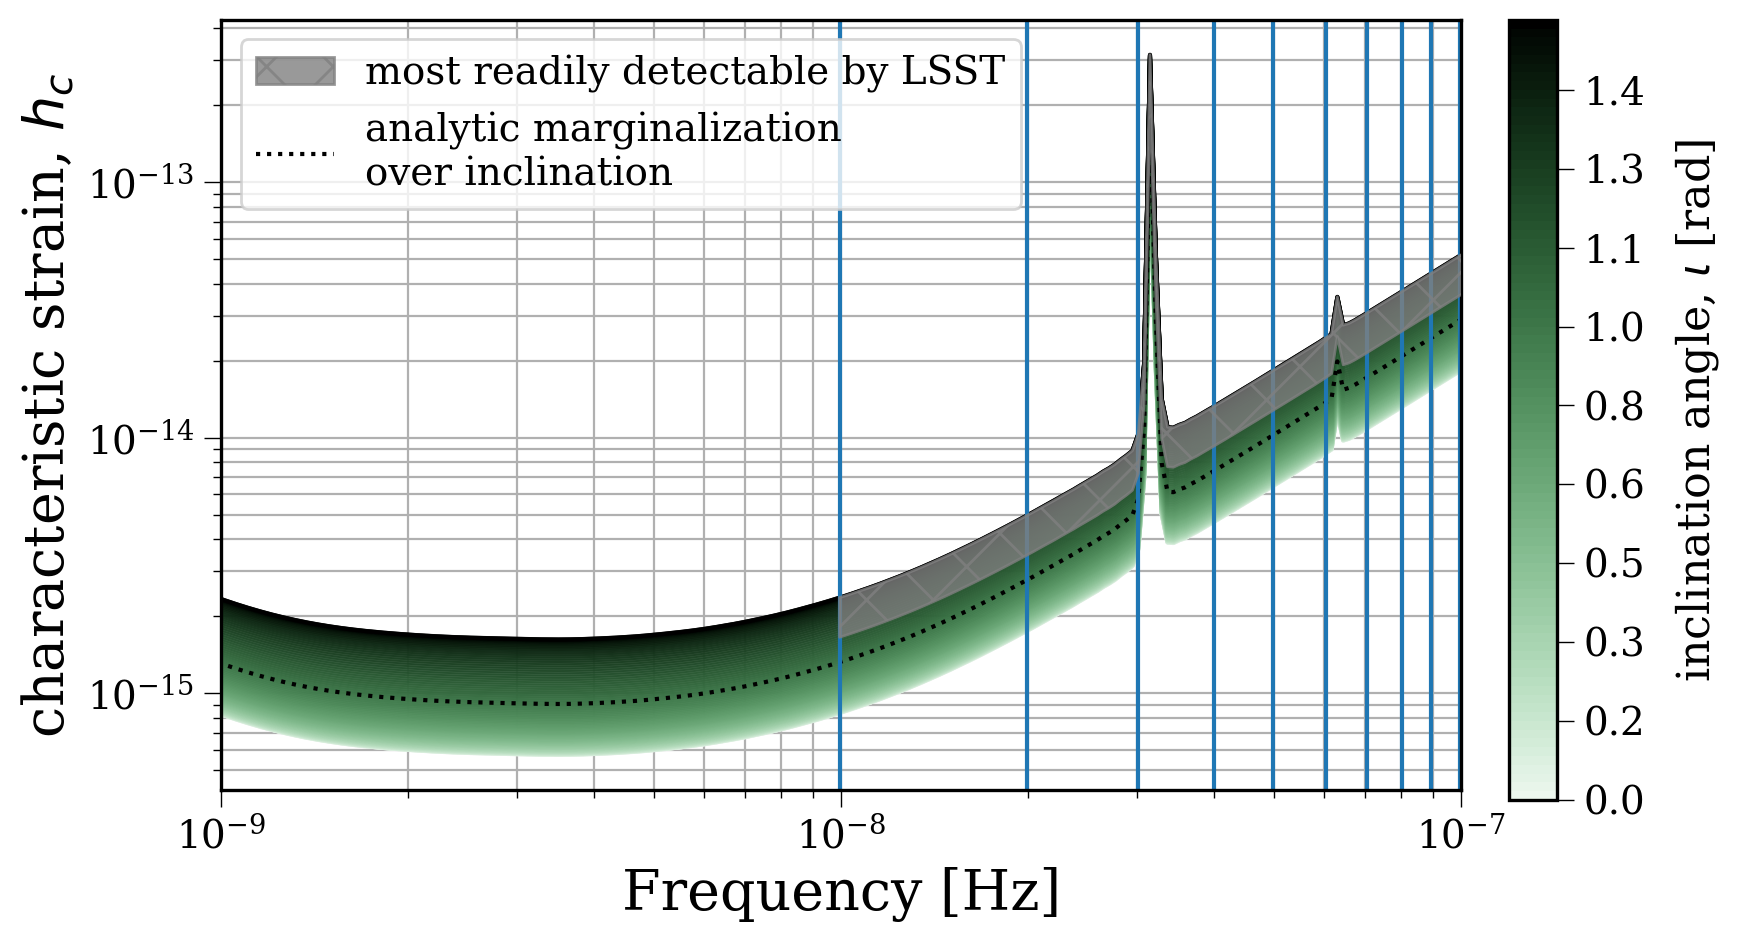

In [60]:
fig = plt.figure(figsize=(8,5))
specific_freq = np.argmin(abs(1e-8-freqs))
for i, iota in enumerate(incs):
    plt.loglog(freqs, np.sqrt(freqs*varied_inc_seff[i]), alpha=0.85,  color=color_map[i])#label=rf"$\iota = {incs[i]:.2f}$",)#label=fr"$\iota=${thup[i]:.2f}", linestyle='--', alpha=0.5)
plt.fill_between(freqs[specific_freq:], np.sqrt(freqs[specific_freq:]*varied_inc_seff[-1][specific_freq:]), np.sqrt(freqs[specific_freq:]*varied_inc_seff[-25][specific_freq:]), alpha=0.8,  color="grey", hatch="x" ,zorder=5, label="most readily detectable by LSST")#label=rf"$\iota = {incs[i]:.2f}$",)#label=fr"$\iota=${thup[i]:.2f}", linestyle='--', alpha=0.5)
plt.loglog(freqs, np.sqrt(freqs*analytic_seff), label="analytic marginalization\nover inclination", color='k', linestyle=':')
# for rr in range(100):
#         plt.scatter(fobs, c_i*hc_ss[:,rr,0], alpha=0.5, color='gray', zorder=2)#color=colors[rr])
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel(r'characteristic strain, $h_{c}$', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
# plt.xlim(1e-8,1e-7)
# plt.ylim(7e-16,1e-13)
plt.xlim(1e-9,1e-7)
#plt.ylim(3e-15,1e-13)
plt.grid(which='both', zorder=0)
for f in freqs[snr_freqs]:
    plt.axvline(f)
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(incs, cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%.1f', norm=norm, boundaries=incs)
ax2.set_ylabel(r'inclination angle, $\iota$ [rad]', fontsize=16,labelpad=10)
ax2.set_yticks([], minor=True)
#plt.savefig(f'{fig_dir}/varying_inclination.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

## lets actually do this with **hc sensitivity** as a funciton of $\iota$ to highlight the important variable

In [61]:
freqs[snr_freqs]

array([9.94689423e-09, 1.99485736e-08, 3.01548764e-08, 4.00070191e-08,
       4.97257454e-08, 6.04758386e-08, 7.04195873e-08, 8.02343873e-08,
       8.94505663e-08, 9.97253683e-08])

In [67]:
incs = np.linspace(0, np.pi/2, 90)
incs_degs = np.linspace(0,90, 90)
color_map = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, n_colors = len(incs), as_cmap=False,)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', color_map, len(color_map))
len(color_map)

90

In [68]:
varied_as_func_inc = np.array([np.mean(SMs[0].S_eff_full(iota=i, psi=None), axis=-1) for i in incs])
varied_as_func_inc.shape

(90, 300)

In [69]:
specific_freq = np.argmin(abs(1e-8-freqs))
Seff_over_incs_at_freq = varied_as_func_inc[:,specific_freq]

In [70]:
hcs_over_incs_at_freq = np.sqrt(specific_freq*Seff_over_incs_at_freq)
hcs_over_incs_at_freq.shape

(90,)

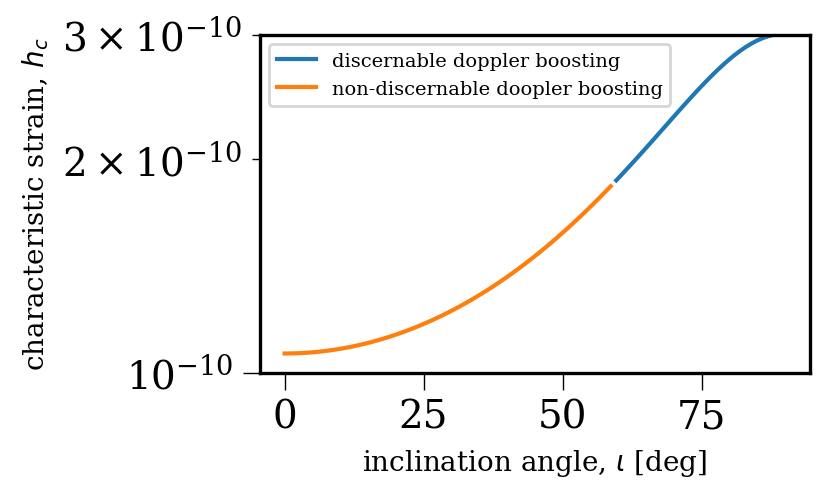

In [73]:
mask1 = int(0.666*len(incs))
plt.semilogy(incs_degs[mask1:], hcs_over_incs_at_freq[mask1:], label="discernable doppler boosting" )
plt.semilogy(incs_degs[:mask1], hcs_over_incs_at_freq[:mask1], label="non-discernable doopler boosting" )
plt.legend()
#plt.xticks([0, np.pi/4, np.pi/2], [0,r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$" ])
#plt.xticks([0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8], minor=True)
plt.ylabel(r'characteristic strain, $h_c$')
plt.xlabel(r'inclination angle, $\iota$ [deg]')
#plt.savefig(f'{fig_dir}/Seff_vs_inclination.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.ylim(2e-10/2, 6e-10/2)
plt.show()
plt.close()

In [74]:
hcs_full = np.sqrt(freqs*varied_as_func_inc)
hcs_full.shape

(90, 300)

In [75]:
cbar_range = freqs[snr_freqs]
color_map = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.75, reverse=True, n_colors = len(cbar_range), as_cmap=False,)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', color_map, len(color_map))

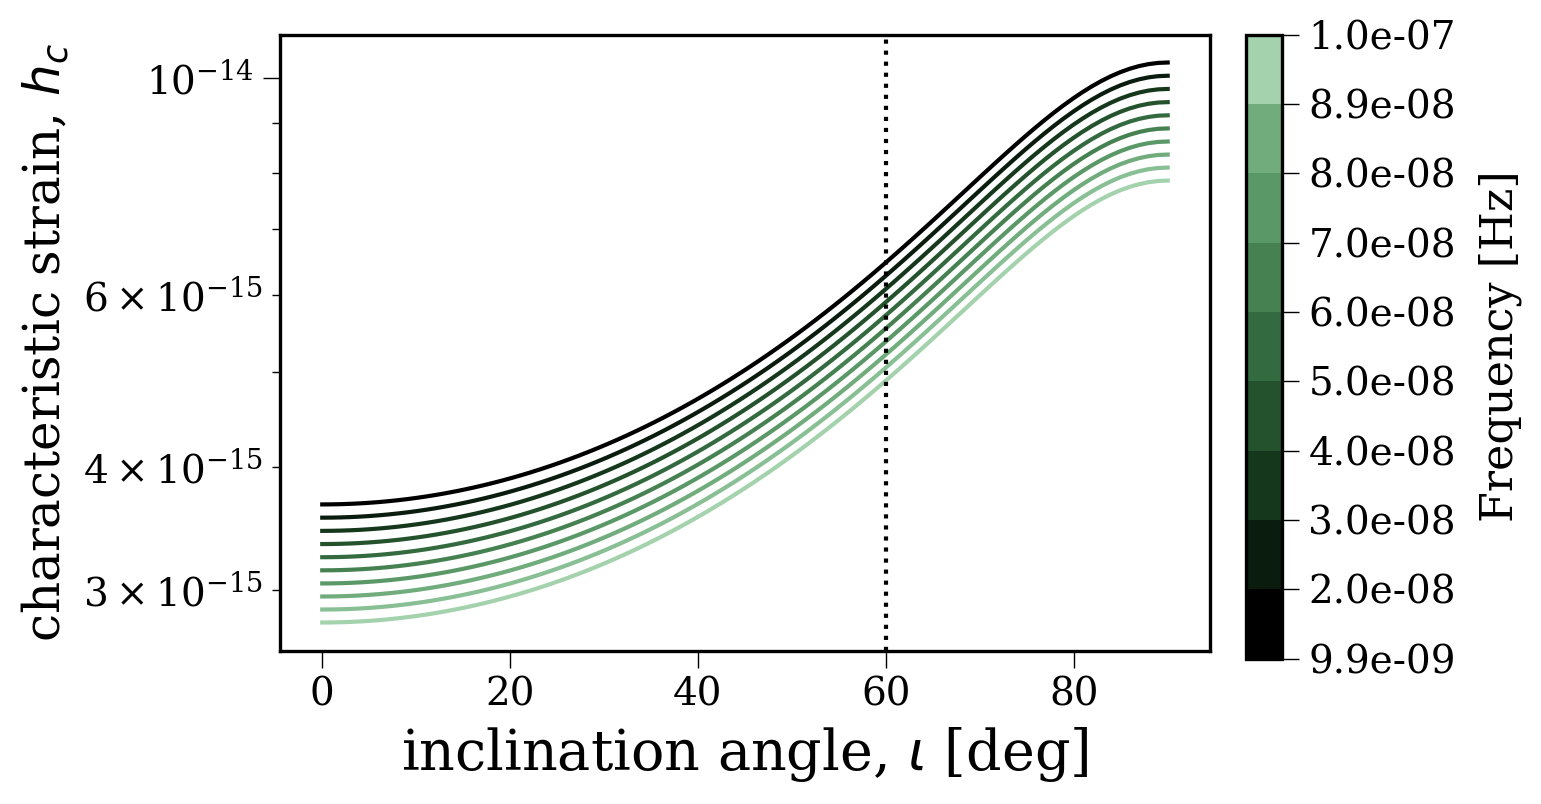

In [76]:
mask1 = int(0.666*len(incs))
fig = plt.figure(figsize=(6,4))
for f, freq in enumerate(cbar_range):
    plt.semilogy(incs_degs, hcs_full[:,f], color=color_map[f])#label="discernable doppler boosting" )
    #plt.semilogy(incs_degs[:mask1], hcs_full[:mask1,f], color=color_map[f])#label="non-discernable doopler boosting" )
plt.axvline(60, color='k', linestyle=':')
#plt.xticks([0, np.pi/4, np.pi/2], [0,r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$" ])
#plt.xticks([0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8], minor=True)
plt.ylabel(r'characteristic strain, $h_c$', fontsize=18)
plt.xlabel(r'inclination angle, $\iota$ [deg]', fontsize=20)
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(cbar_range, cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='uniform', format='%.1e', norm=norm, boundaries=cbar_range)
ax2.set_ylabel("Frequency [Hz]", fontsize=16, labelpad=8)
#plt.savefig(f'{fig_dir}/Seff_vs_inclination.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### ok do this but for SNR

In [78]:
snr_varied_as_func_inc = np.array([np.mean(SMs[0].SNR(1e-14,iota=i, psi=None), axis=-1) for i in incs])
snr_varied_as_func_inc.shape

(90, 300)

In [81]:
snr_freqs = np.array([np.argmin(abs(freqs - f)) for f in np.linspace(1e-8,1e-7,10)])
snr_freqs[-2]+=1 # tiny change for plotting purposes

In [82]:
cbar_range = freqs[snr_freqs]/1e-9
color_map = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.85, reverse=True, n_colors = len(cbar_range), as_cmap=False,)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', color_map, len(color_map))
import matplotlib.ticker as mticker
fomat = mticker.ScalarFormatter(useMathText=True)
fomat.set_powerlimits((-3,3))
def fmt(x,b):
    return  '{:.0f}'.format(round(x,-1))
    #return r'${} \times 10^{{{}}}$'.format(a, b)

In [83]:
nhz = freqs[snr_freqs]/1e-9

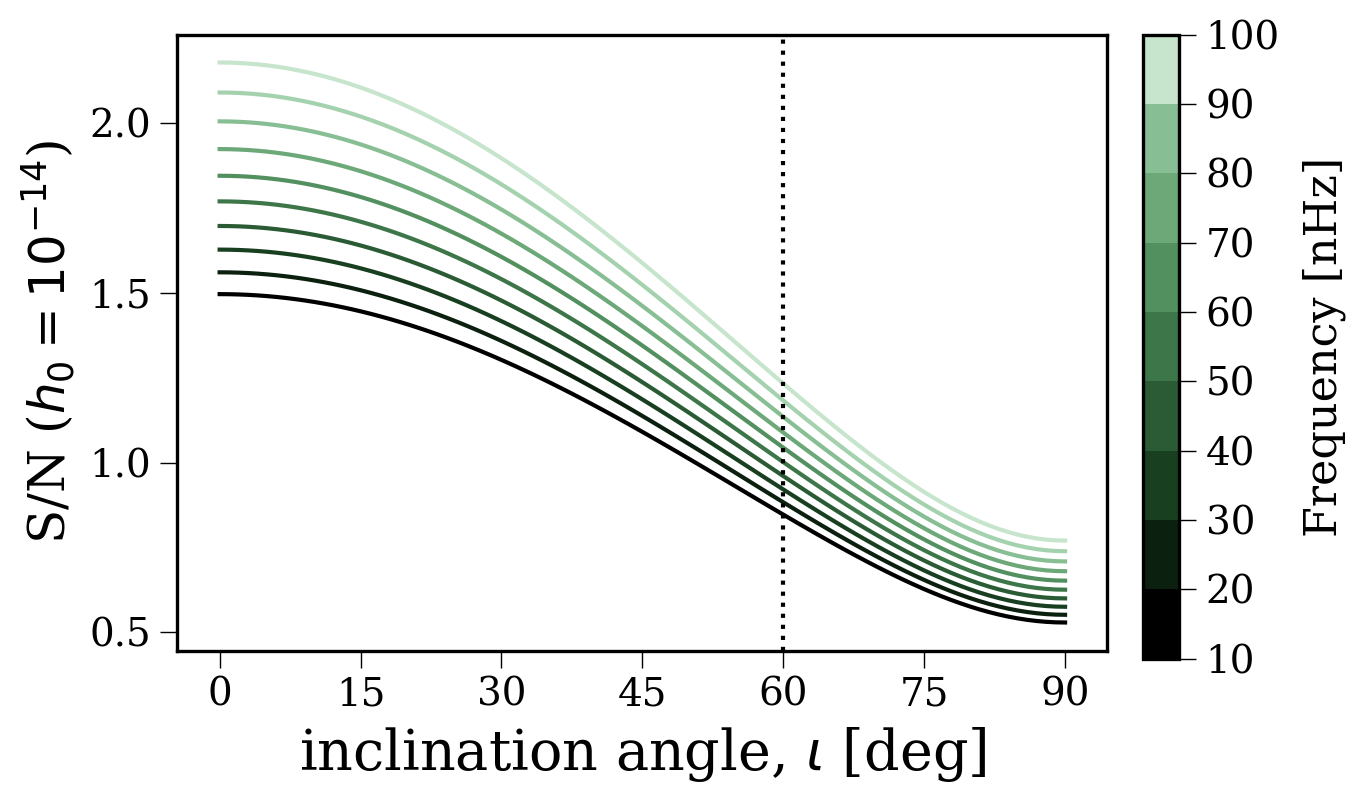

In [ ]:
mask1 = int(0.666*len(incs))
fig = plt.figure(figsize=(6,4))
for f, freq in enumerate(cbar_range*1e-9):
    plt.plot(incs_degs, snr_varied_as_func_inc[:,f], color=color_map[f])#label="discernable doppler boosting" )
plt.axvline(60, color='k', linestyle=':')
plt.xticks([0, 15,30,45,60,75,90],)
#plt.xticks([0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8], minor=True)
plt.ylabel(r'S/N ($h_0 = 10^{-14}$)', fontsize=18)
plt.xlabel(r'inclination angle, $\iota$ [deg]', fontsize=20)
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(cbar_range, cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='uniform', format=fmt, norm=norm, boundaries=cbar_range)
    #for exponential below
    #spacing='uniform', format=ticker.FuncFormatter(fmt), norm=norm, boundaries=cbar_range)
ax2.set_ylabel("Frequency [nHz]", fontsize=16, labelpad=8)
#ax2.set_yticks([int(i) for i in np.linspace(10,100,10)])
#plt.savefig(f'{fig_dir}/snr_vs_inclination.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

In [52]:
##### dev this later !! hc senstivity functionality for a non-inclination averaged skymap
# def hc_inc(skymap, iota=None):
#     """Characteristic strain sensitivity extended to calculations with iota and psi"""
#     h_c = np.sqrt(skymap.freqs[:,np.newaxis] * skymap.S_eff_full(iota=, psi=None))
#     return h_c

# 4) Now compare the alt campaign to new physics PSDs

In [ ]:
# try to import new physics psds courtesy of Andrea Mitridate
from scripts.new_physics_scripts import *

In [63]:
GWBSNRs = []
GWBSCs = []
SMs = []
hpsrs = reset_psrs()
noise_before = {}
noise_after = {}
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 690
1:4) reducing pulsar  J0326+0145
old: 792, new: 692
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 561
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1135+0251
old: 684, new: 584
2:2) reducing pulsar  J2100-0048
old: 557, new: 457
2:3) reducing pulsar  J2052+0211
old: 550, new: 450
2:4) reducing pulsar  J1514-0303
old: 646, new: 546
2:5) reducing pulsar  J0122-0052
old: 566, new: 466
2:6) reducing pulsar  J2028-0020
old: 789, new: 689
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J1726+0347
old: 658, new: 558
3:2) reducing puls

In [64]:
# here i redefine the omega gw function to return the new-physics version of omega 
# this includes a factor of h^2 and typically uses 67 for hubble constant
hsq = ((67*u.km/u.Mpc/u.s) / (100*u.km/u.Mpc/u.s))**2
def hsq_Omega_gw(sensitivity_curve, H_0=67*u.km/u.Mpc/u.s):
    """Energy Density sensitivity"""
    Omega_gw = ((2*np.pi**2/3) * sensitivity_curve.freqs**3 * sensitivity_curve.S_eff_mean
                        / H_0.to('Hz').value**2)
    return Omega_gw * (H_0/(100*u.km/u.Mpc/u.s))**2
def hsq_Omega_gw_S_eff(sensitivity_curve, H_0=67*u.km/u.Mpc/u.s):
    """Energy Density sensitivity"""
    Omega_gw = ((2*np.pi**2/3) * sensitivity_curve.freqs**3 * sensitivity_curve.S_eff
                        / H_0.to('Hz').value**2)
    return Omega_gw * (H_0/(100*u.km/u.Mpc/u.s))**2

In [65]:
test_deter = hsen.DeterSensitivityCurve(spectra=spectra, A_GWB=A_gwb, pulsar_term=True)
test_gwb = hsen.GWBSensitivityCurve(spectra=spectra)
test_skymap = hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw)

### the GWB and deter/skymap sensitvity curves are different here
#### (i think we should use the deterministic SC)

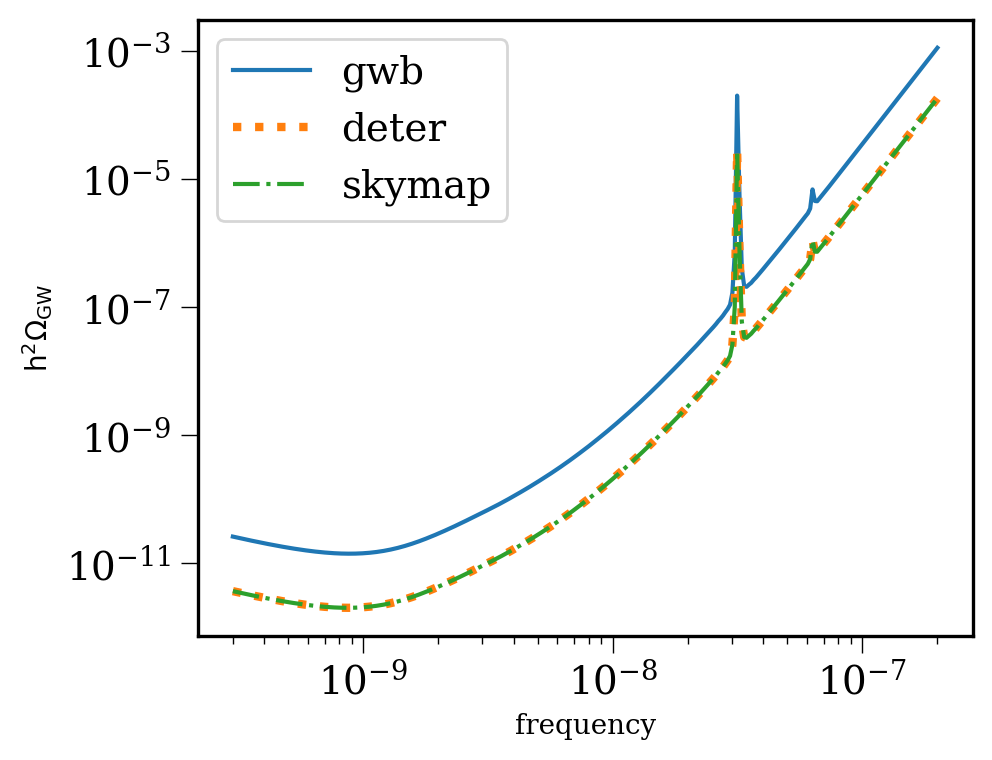

In [66]:
fig = plt.figure(figsize=(5,4))
plt.loglog(test_gwb.freqs,hsq_Omega_gw_S_eff(test_gwb), label='gwb')
plt.loglog(test_gwb.freqs,hsq_Omega_gw_S_eff(test_deter), linestyle=':', label='deter', linewidth=3)
plt.loglog(test_gwb.freqs,hsq_Omega_gw(test_skymap), linestyle='-.', label='skymap')
plt.legend(fontsize=14)
plt.xlabel('frequency')
plt.ylabel(r'$\rm h^2\Omega_{GW}$')
plt.show()
plt.close()

## import the new physics stuff and construct PSDs from the MLV params from the Table 4 in the appendix 
##### https://iopscience.iop.org/article/10.3847/2041-8213/acdc91/pdf

###### shout out new physics folks for the nice code

In [67]:
from new_physics_scripts import (igw, sigw_delta, sigw_gauss, sigw_box,
                                 pt_bubble, pt_sound,stable_c, stable_k,
                                 stable_m, stable_n, meta_l, meta_ls,
                                 super, dw_sm, dw_ds)

In [68]:
new_physics_spectra = {
    "IGW": igw.spectrum(freqs, 2.02, -10.14, -0.53),
    "SIGW-DELTA": sigw_delta.spectrum(freqs, -5, -0.14),
    "SIGW-GAUSS": sigw_gauss.spectrum(freqs, -0.34,1.6, -7.03,),
    "SIGW-BOX": sigw_box.spectrum(freqs, -1.26, -7.50, -5.40,),
    "PT-BUBBLE": pt_bubble.spectrum(freqs,1, -0.78, 0, 2.14, 3, 1),
    "PT-SOUND": pt_sound.spectrum(freqs, -0.01, -1.75, -0.82, 3, 2, 5),
    "STABLE-C": stable_c.spectrum(freqs, -10.18, ),
    "STABLE-K": stable_k.spectrum(freqs, -10.36),
    "STABLE-M": stable_m.spectrum(freqs, -10.56,),
    "STABLE-N": stable_n.spectrum(freqs, -10.21),
    #"META-L": meta_l.spectrum(freqs, -5.04, 7.85),
    #"META-LS": meta_ls.spectrum(freqs, -4.46, 7.61),
    "SUPER": super.spectrum(freqs, -11.94, -3),
    "DW-SM": dw_sm.spectrum(freqs, -0.92, -0.79, 0.5, 3),
    "DW-DR": dw_ds.spectrum(freqs, -0.41, -0.94, 0.5, 3)
}

In [69]:
new_physics_names = {
    "IGW": "inflationary GWs",
    "SIGW-DELTA": "scalar-induced GW Delta",
    "SIGW-GAUSS": "scalar-induced GW Gauss",
    "SIGW-BOX": "scalar-induced GW box",
    "PT-BUBBLE": "cosmological phase transition bubble",
    "PT-SOUND": "cosmological phase transition sound",
    "STABLE-C": "cosmic strings: cusp-only spectrum",
    "STABLE-K": "cosmic strings: kink-only spectrum",
    "STABLE-M": "cosmic strings: monochromatic emission",
    "STABLE-N": "cosmic strings: numerical spectrum",
    #"META-L": "metastable cosmic strings: loops only",
    #"META-LS": "metastable cosmic strings: loops and segments",
    "SUPER": "cosmic superstrings",
    "DW-SM": "domain walls: standard model",
    "DW-DR": "domain walls: dark radiation"
    
}

In [70]:
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [71]:
len(SMs), len(GWBSCs)

(11, 11)

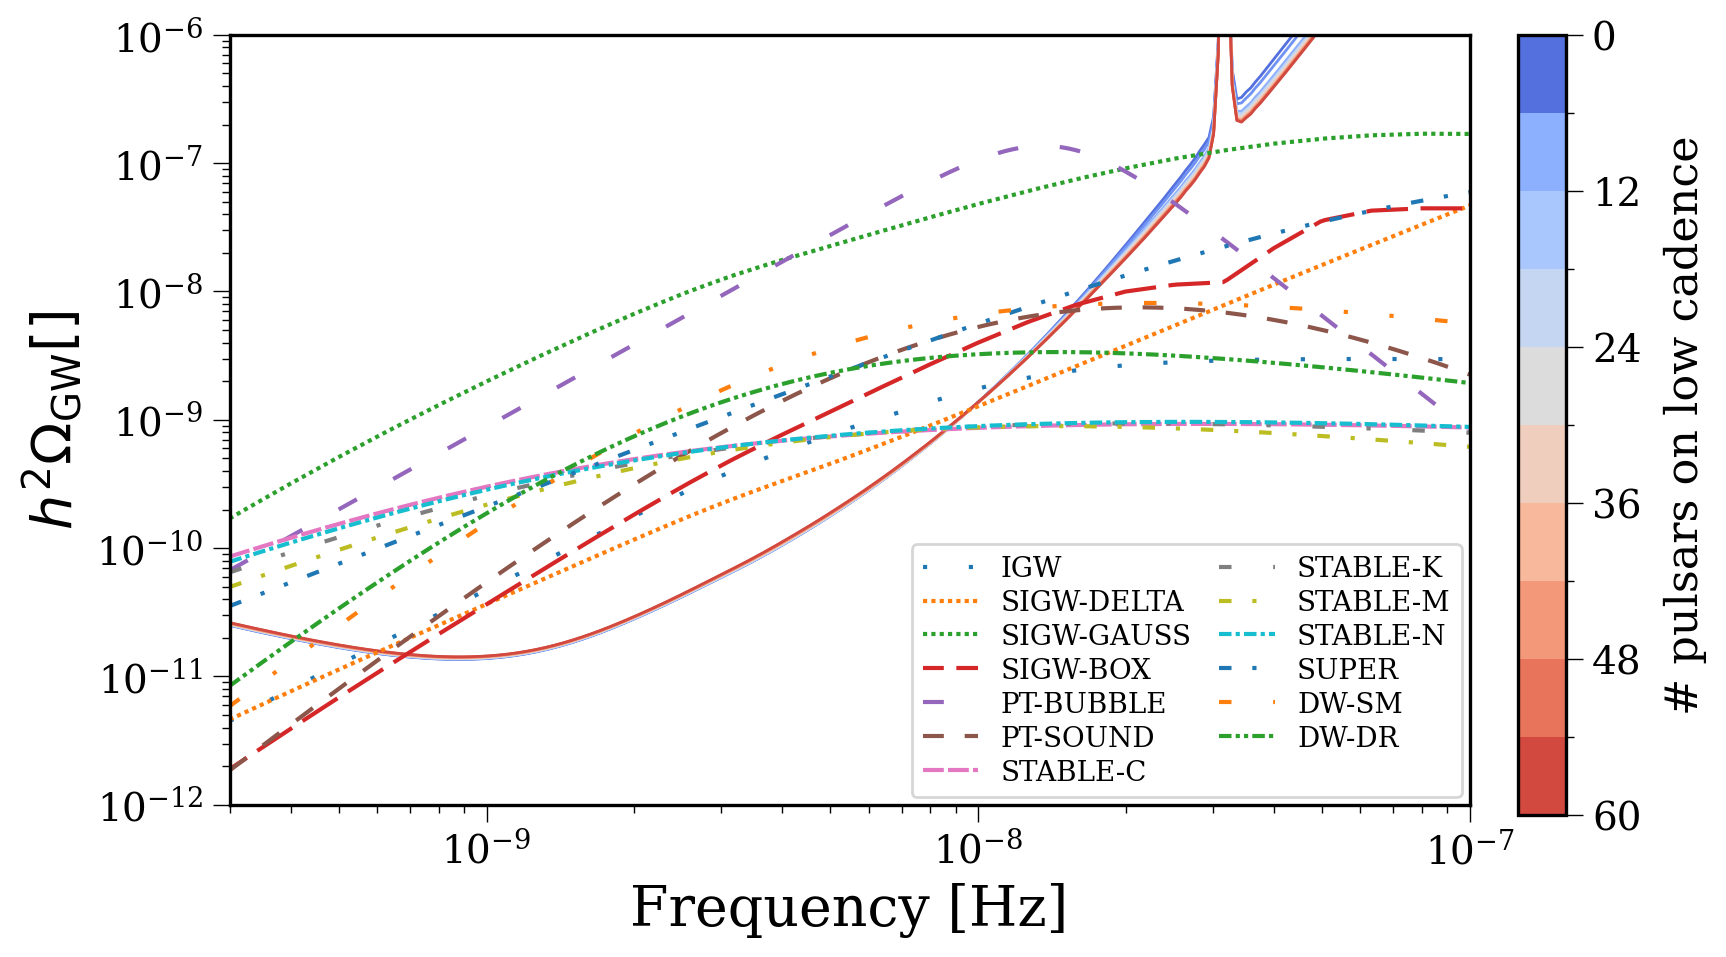

In [72]:
dropped = pulsars_dropped_per_year*np.array([i for i in range(0,len(SMs))])
color_map = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(SMs))
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', np.flip(color_map, axis=0), len(color_map))
fig = plt.figure(figsize=(8,5))
for i in range(len(SMs)):
    plt.loglog(freqs,hsq_Omega_gw_S_eff(GWBSCs[i]), linestyle='-', linewidth=1, color=color_map[i])
for i, key in enumerate(list(new_physics_spectra.keys())):
    plt.loglog(freqs, new_physics_spectra[key], linestyle=linestyle_tuple[i][1], color=f"C{i}", label =f"{key}", linewidth=1.5)
plt.legend(loc=(0.55, 0.01), fontsize=10, ncols=2, labelspacing=0.25,columnspacing=1)
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel(r'$h^2\Omega_{\rm GW} [] $', fontsize=20)
plt.ylim(1e-12, 1e-6)
plt.xlim(3e-10, 1e-7)
#### cbar 
ax2 = fig.add_axes([0.93, 0.1, 0.03, 0.78])
norm = mpl.colors.BoundaryNorm(np.flip(dropped), cmap.N)
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
    spacing='proportional', format='%1i', norm=norm, boundaries=np.flip(dropped),ticklocation='right')
ax2.set_ylabel('# pulsars on low cadence', fontsize=16, labelpad=8)
for label in ax2.get_yticklabels(minor=True):
    label.set_verticalalignment('center')
#plt.savefig(f'{fig_dir}/new_physics_comparison_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

In [73]:
new_physics_snr_change = {
    model: [
        GWBSC.SNR(new_physics_spectra[model]/hsq) for GWBSC in GWBSCs
        ] for model in list(new_physics_spectra.keys())
}

In [74]:
len((new_physics_snr_change['DW-DR']-new_physics_snr_change['DW-DR'][0])/new_physics_snr_change['DW-DR'][0])

11

In [75]:
swaps = np.linspace(0,iterations, iterations+1)
swaps

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [80]:
np.arange(0,60,6)

array([ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54])

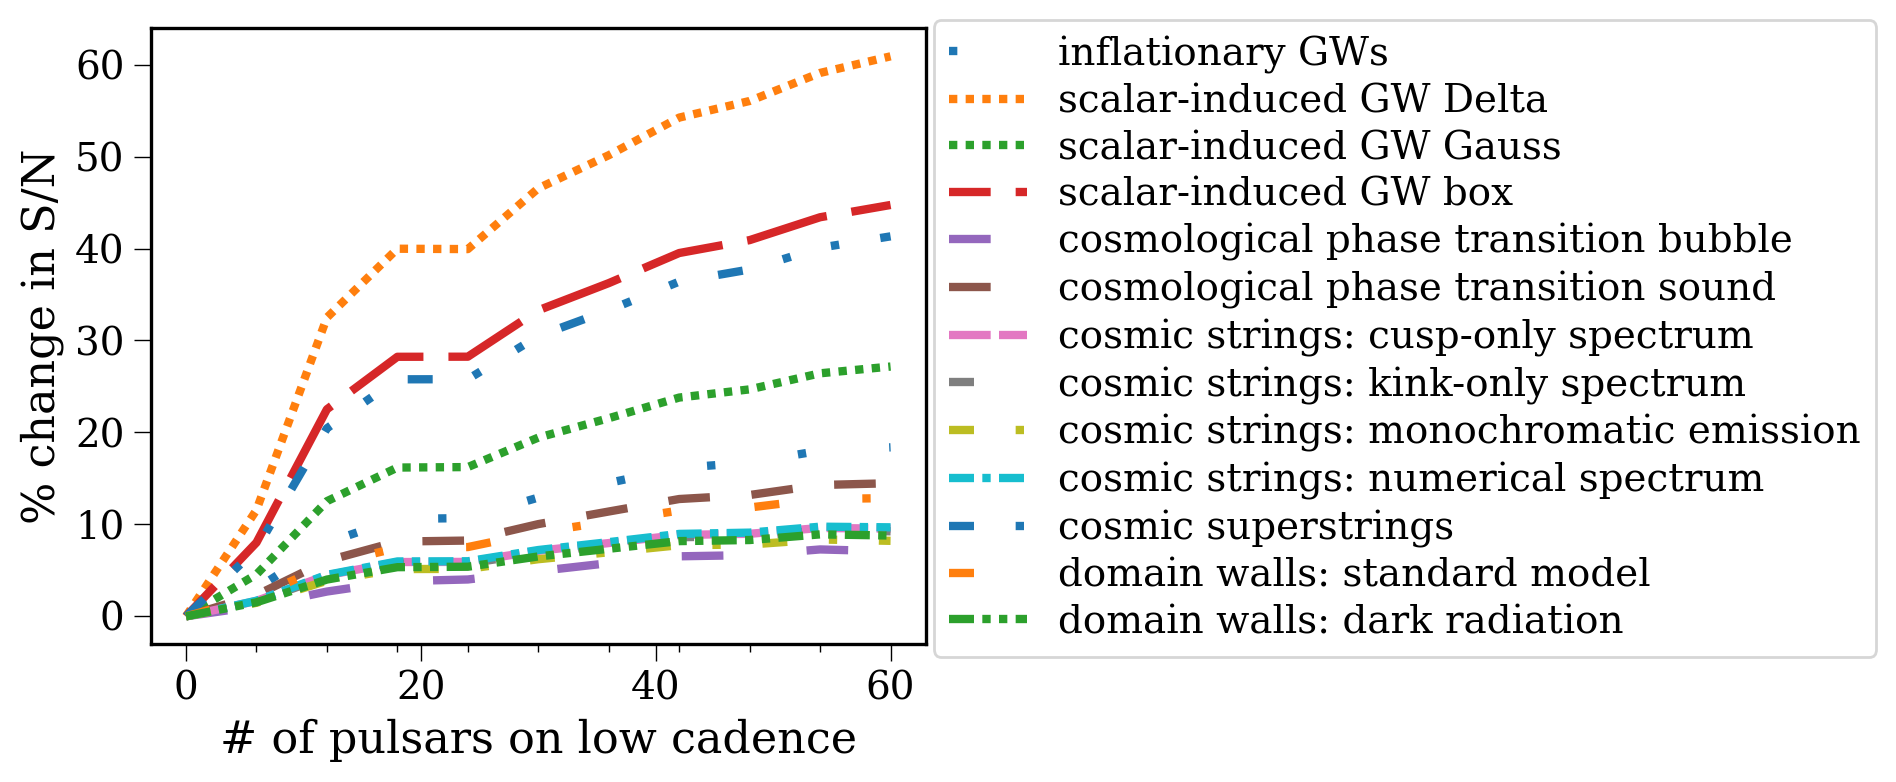

In [82]:
fig = plt.figure(figsize=(5,4))
swaps = pulsars_dropped_per_year*np.linspace(0,iterations, iterations+1)
for i, model in enumerate(list(new_physics_snr_change.keys())):
    plt.plot(swaps, 100*(new_physics_snr_change[model]-new_physics_snr_change[model][0])/new_physics_snr_change[model][0],
             label=new_physics_names[model], linestyle=linestyle_tuple[i][1], color=f"C{i}", linewidth=3)
plt.xticks(np.arange(0,60,6), minor=True)
plt.legend(loc=(1.01, -0.02), fontsize=14, ncols=1, labelspacing=0.25,columnspacing=1)
plt.xlabel("# of pulsars on low cadence", fontsize=16)
plt.ylabel("% change in S/N", fontsize=16)
plt.savefig(f'{fig_dir}/new_physics_snr_comparison_v2.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### probably actually see a turnover in NEW PYSICS snrs because they go from low freq to high freq
### maybe a reason we probably didnt see a turnover when jeff did (for CW) is because we are doing this with more pulsars than Jeff did previously. more pulsars help insulate the background from really hurting you?

In [61]:
hsen.GWBSensitivityCurve?

Init signature: hsen.GWBSensitivityCurve(spectra, orf='hd', autocorr=False)
Docstring:     
Class to produce a sensitivity curve for a gravitational wave
background, using Hellings-Downs spatial correlations.

Parameters
----------
orf : str, optional {'hd', 'st', 'dipole', 'monopole'}
    Overlap reduction function to be used in the sensitivity curve.
    Maybe be Hellings-Downs, Scalar-Tensor, Dipole or Monopole.
File:           ~/src/hasasia/hasasia/sensitivity.py
Type:           type
Subclasses:     

# 5) What if we did this for alt. pol // various ORFs too?

In [150]:
GWBSNRs = []
GWBSCs = []
st = []
dipoles = []
monopoles = []
hpsrs = reset_psrs()
noise_before = {}
noise_after = {}
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
monopoles.append(hsen.GWBSensitivityCurve(spectra, orf='monopole'))
dipoles.append(hsen.GWBSensitivityCurve(spectra, orf='dipole')) 
st.append(hsen.GWBSensitivityCurve(spectra, orf='st'))
#SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
for i, psr_hcad in enumerate(psrs_high_cad): # # enumerate([psrs_high_cad[0]]):
    # reduce pulsars with .filter_data() function
    for idx in range(pulsars_dropped_per_year):
        print(f"{i+1}:{idx+1}) reducing pulsar ", hpsrs[psrs_removed[i*pulsars_dropped_per_year+idx]].name)
        hpsrs[psrs_removed[pulsars_dropped_per_year*i+idx]].change_cadence(
                start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                cadence=None, cadence_factor=thin_cadence_factor, uneven=True,
                A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,)
    # altar cadences with .change_cadence()
    print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
    print("toas before: ", len(hpsrs[psr_hcad].toas))
    hpsrs[psr_hcad].change_cadence(
        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
        cadence=None, cadence_factor=cadence_factor, uneven=True,
        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
        )
    # create psr spectra at end of cadence
    spectra = get_sliced_spectra(
            psrs=hpsrs,
            start_mjd=-1000,
            end_mjd=end_year*365.25
            )
    GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
    monopoles.append(hsen.GWBSensitivityCurve(spectra, orf='monopole'))
    dipoles.append(hsen.GWBSensitivityCurve(spectra, orf='dipole')) 
    st.append(hsen.GWBSensitivityCurve(spectra, orf='st'))
    #SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    GWBSNRs.append(GWBSCs[-1].SNR(S_h))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
1:1) reducing pulsar  J2223+0357
old: 551, new: 451
1:2) reducing pulsar  J0634+0328
old: 550, new: 449
1:3) reducing pulsar  J1015+0331
old: 791, new: 690
1:4) reducing pulsar  J0326+0145
old: 792, new: 692
1:5) reducing pulsar  J2154-0231
old: 691, new: 591
1:6) reducing pulsar  J1535-0011
old: 662, new: 561
quadrupuling pulsar  J1907-0212
toas before:  694
old: 694, new: 1293
PTA spectrum with 133 psrs created.
2:1) reducing pulsar  J1135+0251
old: 684, new: 584
2:2) reducing pulsar  J2100-0048
old: 557, new: 457
2:3) reducing pulsar  J2052+0211
old: 550, new: 450
2:4) reducing pulsar  J1514-0303
old: 646, new: 546
2:5) reducing pulsar  J0122-0052
old: 566, new: 466
2:6) reducing pulsar  J2028-0020
old: 789, new: 689
quadrupuling pulsar  J1900-0226
toas before:  562
old: 562, new: 1159
PTA spectrum with 133 psrs created.
3:1) reducing pulsar  J1726+0347
old: 658, new: 558
3:2) reducing puls

In [151]:
testst = st[0]

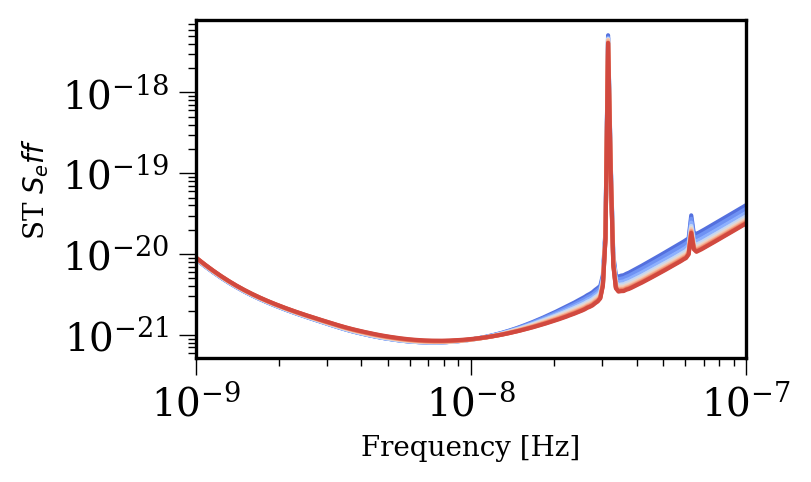

In [157]:
for i, s in enumerate(st):
    plt.loglog(freqs, s.S_eff, color = color_map[i])
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ST $S_eff$')
plt.xlim(1e-9,1e-7)
plt.show()

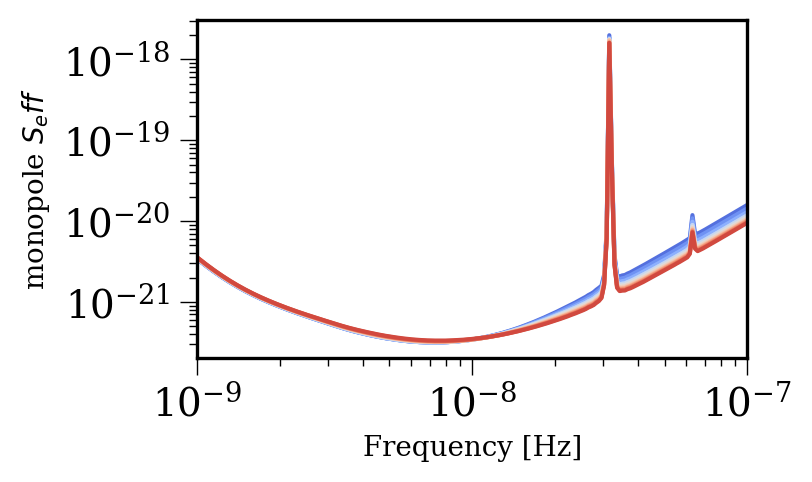

In [162]:
for i, s in enumerate(monopoles):
    plt.loglog(freqs, s.S_eff, color = color_map[i])
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'monopole $S_eff$')
plt.xlim(1e-9,1e-7)
plt.show()

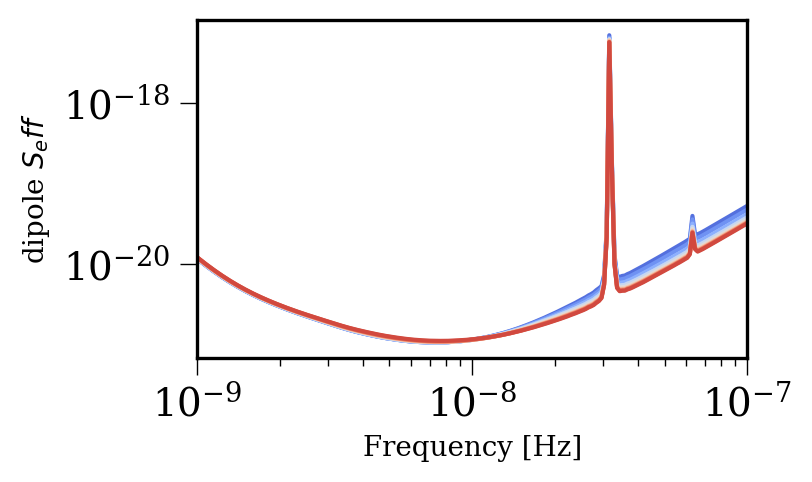

In [163]:
for i, s in enumerate(dipoles):
    plt.loglog(freqs, s.S_eff, color = color_map[i])
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'dipole $S_eff$')
plt.xlim(1e-9,1e-7)
plt.show()

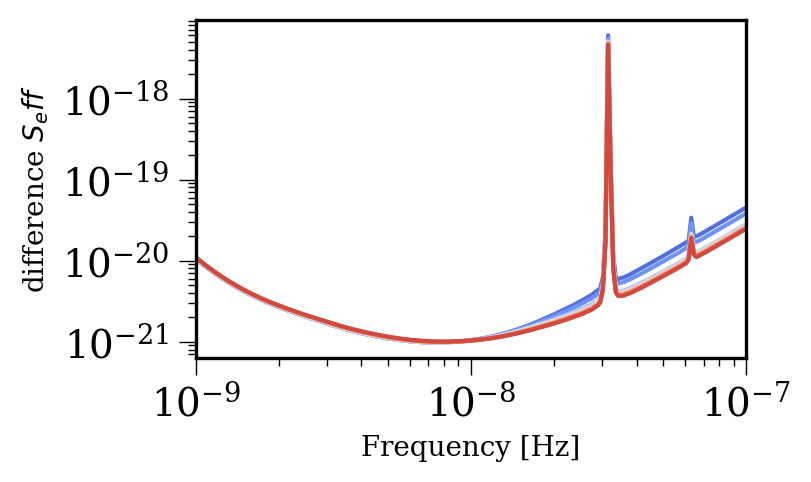

In [164]:
for i, s in enumerate(GWBSCs):
    plt.loglog(freqs, s.S_eff-dipoles[i].S_eff, color = color_map[i])
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'difference $S_eff$')
plt.xlim(1e-9,1e-7)
plt.show()

### not insanely interesting